In [73]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
import math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
#z is used as the third feature
def get_data(n_samples, noise_level=0.1):
    np.random.seed(42)
    x1 = np.random.normal(size=n_samples)
    x2 = np.random.normal(size=n_samples)
    z = np.random.normal(size=n_samples)  
    y = 3 * x1 + 2 * x2 + noise_level * np.random.normal(size=n_samples)  
    return pd.DataFrame({'x1': x1, 'x2': x2, 'z': z, 'y': y})

datasets = [get_data(n) for n in list(np.arange(200,10000,500))]

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc3(x)
        return x
model = RegressionModel()

def train_model(model, train_loader, epochs=50):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

In [3]:
models = []
for data in datasets:
    model = RegressionModel()
    X = torch.tensor(data[['x1', 'x2', 'z']].values, dtype=torch.float32)
    y = torch.tensor(data['y'].values, dtype=torch.float32).view(-1, 1)
    dataset = TensorDataset(X, y)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    train_model(model, train_loader)
    models.append(model)

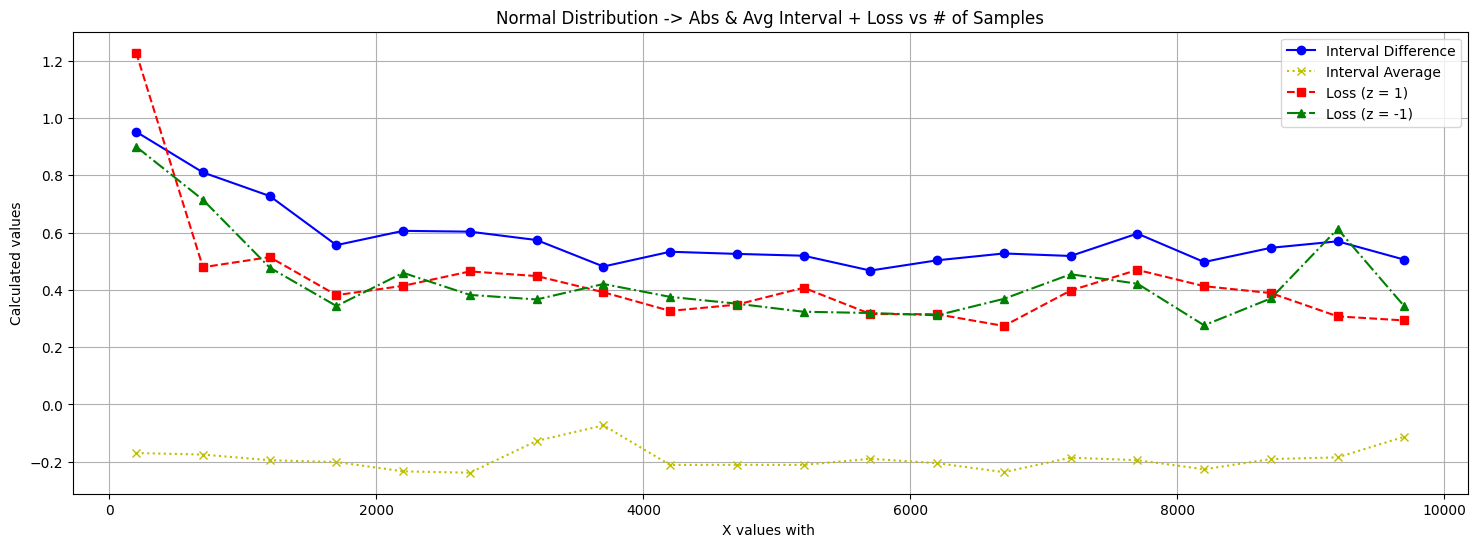

In [23]:
#normal distribution x_test with constant z(-1,1) -> interval + loss func
X_test = get_data(10000)[['x1', 'x2','z','y']]

intervals = []
avg_intervals = []
losses_z1 = []
losses_z_minus1 = []
loss_fn = nn.MSELoss()

for model in models:
    model_intervals = []
    model_avg_intervals = []
    model_losses_z1 = []
    model_losses_z_minus1 = []
    for i in range(200):
        x1 = X_test.iloc[i]['x1']
        x2 = X_test.iloc[i]['x2']
        y = X_test.iloc[i]['y']
        target = np.array([y], dtype=np.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32).unsqueeze(0)
        predictions = []
        for z in [1, -1]:
            input_data = np.array([x1, x2, z], dtype=np.float32)
            input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():  
                preds = model(input_tensor)
            predictions.append(preds.numpy())
        
        # Use 'y' as the target for the loss calculation
        loss_z1 = loss_fn(torch.tensor(predictions[0], dtype=torch.float32), target_tensor)
        loss_z_minus1 = loss_fn(torch.tensor(predictions[1], dtype=torch.float32), target_tensor)

        model_losses_z1.append(loss_z1.item())
        model_losses_z_minus1.append(loss_z_minus1.item())

        #abs diff with interval 
        interval = np.abs(predictions[0] - predictions[1])
        model_intervals.append(interval)

        #avg interval
        avg = (predictions[0]+predictions[1])/2
        model_avg_intervals.append(avg)
        
    intervals.append(model_intervals)
    avg_intervals.append(model_avg_intervals)
    losses_z1.append(model_losses_z1)
    losses_z_minus1.append(model_losses_z_minus1)
    
intervals = np.array(intervals)
intervals = np.squeeze(intervals)
nd_intervals = np.array([np.mean(i) for i in intervals])
avg_intervals = np.array(avg_intervals)
avg_intervals = np.squeeze(avg_intervals)
nd_avg_intervals = np.array([np.mean(i) for i in avg_intervals])
losses_z1 = np.array(losses_z1)
nd_losses_z1 = np.array([np.mean(i) for i in losses_z1])
losses_z_minus1 = np.array(losses_z_minus1)
nd_losses_z_minus1 = np.array([np.mean(i) for i in losses_z_minus1])

x_values = list(np.arange(200, 10000, 500))

# Plotting
plt.figure(figsize=(18, 6))

plt.plot(x_values, nd_intervals, marker='o', linestyle='-', color='b', label='Interval Difference')
plt.plot(x_values, nd_avg_intervals, marker='x', linestyle=':', color='y', label='Interval Average')
plt.plot(x_values, nd_losses_z1, marker='s', linestyle='--', color='r', label='Loss (z = 1)')
plt.plot(x_values, nd_losses_z_minus1, marker='^', linestyle='-.', color='g', label='Loss (z = -1)')

plt.xlabel('X values with ')
plt.ylabel('Calculated values')
plt.title('Normal Distribution -> Abs & Avg Interval + Loss vs # of Samples')
plt.grid(True)
plt.legend()
plt.show()

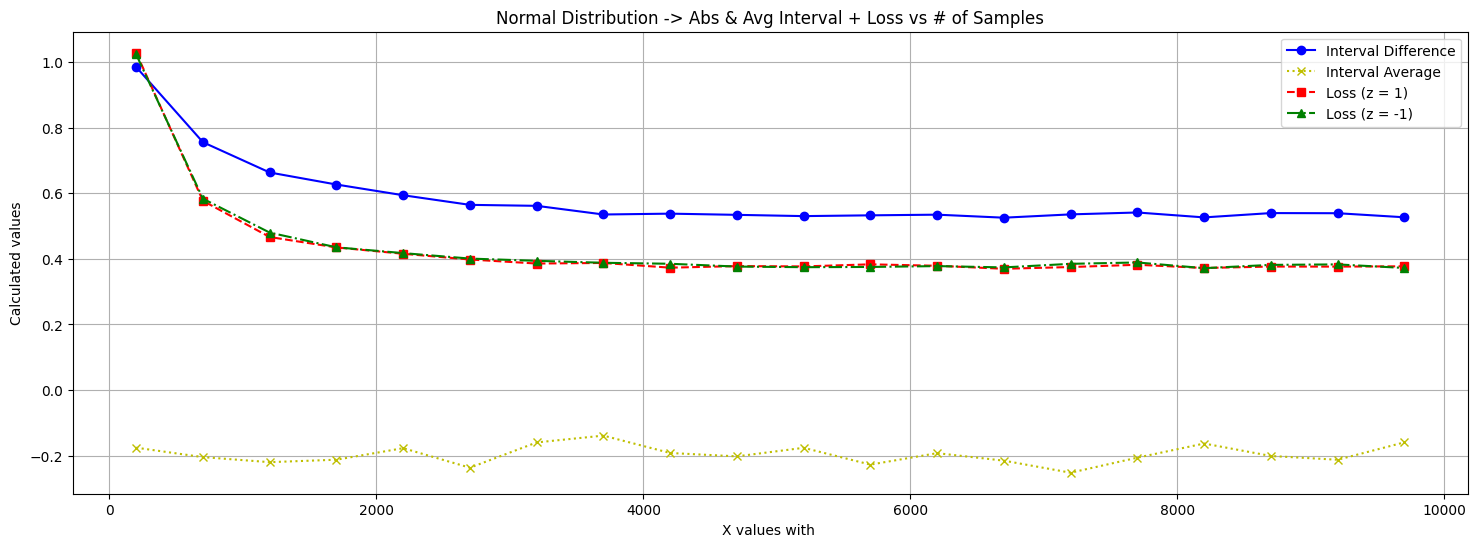

In [96]:
#normal distribution x_test + z -> interval + loss func
random_z = np.random.normal(size=10000)
X_test = get_data(10000)[['x1', 'x2','z','y']]

# Initialize empty lists to store results
intervals = []
avg_intervals = []
losses_z1 = []
losses_z_minus1 = []
between = []
equal = []
z_and_y = []
# Define the loss function
loss_fn = nn.MSELoss()

# Iterate over each model
for model in models:
    model_intervals = []
    model_avg_intervals = []
    model_losses_z1 = []
    model_losses_z_minus1 = []

    # Iterate over each instance in the test set
    for i in range(200):
        x1 = X_test.iloc[i]['x1']
        x2 = X_test.iloc[i]['x2']
        y = X_test.iloc[i]['y']
        target = np.array([y], dtype=np.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

        # Iterate over a range of z values from the random normal distribution
        for z_iterate in range(200):
            z_arr = [random_z[np.random.randint(len(random_z))],random_z[np.random.randint(len(random_z))]]
            
            predictions = []
            for z in z_arr:
                input_data = np.array([x1, x2, z], dtype=np.float32)
                input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)
                
                # Predict without gradient calculation
                with torch.no_grad():
                    preds = model(input_tensor)
                predictions.append(preds.numpy())
                z_and_y.append((z,preds.item()))
            
            #find z interval that capture target
            squeezed_predictions = np.squeeze(predictions)
            min_z = min(squeezed_predictions[0],squeezed_predictions[1])
            max_z = max(squeezed_predictions[0],squeezed_predictions[1])
            if(min_z<=target_tensor.item()<=max_z):
                between.append((min_z, max_z, target_tensor.item()))
            
            #find min, max z that = target ; #if(math.isclose(i, target_tensor.item(), abs_tol=0.001)):
            for index, i in enumerate(squeezed_predictions):
                if(math.isclose(i, target_tensor.item(), abs_tol=0.000001)):
                    equal.append(z_arr[index])
                
            # Calculate loss using 'y' as the target
            loss_z1 = loss_fn(torch.tensor(predictions[0], dtype=torch.float32), target_tensor)
            loss_z_minus1 = loss_fn(torch.tensor(predictions[1], dtype=torch.float32), target_tensor)

            model_losses_z1.append(loss_z1.item())
            model_losses_z_minus1.append(loss_z_minus1.item())

            # Calculate the absolute difference between predictions (interval)
            interval = np.abs(predictions[0] - predictions[1])
            model_intervals.append(interval)

            # Calculate the average of predictions
            avg = (predictions[0] + predictions[1]) / 2
            model_avg_intervals.append(avg)

    # Store the results for each model
    intervals.append(model_intervals)
    avg_intervals.append(model_avg_intervals)
    losses_z1.append(model_losses_z1)
    losses_z_minus1.append(model_losses_z_minus1)

intervals = np.array(intervals)
intervals = np.squeeze(intervals)
ndz_intervals = np.array([np.mean(i) for i in intervals])
avg_intervals = np.array(avg_intervals)
avg_intervals = np.squeeze(avg_intervals)
ndz_avg_intervals = np.array([np.mean(i) for i in avg_intervals])
losses_z1 = np.array(losses_z1)
ndz_losses_z1 = np.array([np.mean(i) for i in losses_z1])
losses_z_minus1 = np.array(losses_z_minus1)
ndz_losses_z_minus1 = np.array([np.mean(i) for i in losses_z_minus1])

x_values = list(np.arange(200, 10000, 500))

# Plotting
plt.figure(figsize=(18, 6))

plt.plot(x_values, ndz_intervals, marker='o', linestyle='-', color='b', label='Interval Difference')
plt.plot(x_values, ndz_avg_intervals, marker='x', linestyle=':', color='y', label='Interval Average')
plt.plot(x_values, ndz_losses_z1, marker='s', linestyle='--', color='r', label='Loss (z = 1)')
plt.plot(x_values, ndz_losses_z_minus1, marker='^', linestyle='-.', color='g', label='Loss (z = -1)')

plt.xlabel('X values with ')
plt.ylabel('Calculated values')
plt.title('Normal Distribution -> Abs & Avg Interval + Loss vs # of Samples')
plt.grid(True)
plt.legend()
plt.show()

In [76]:
#tightest interval for z(z1,z2) to have a prediction interval that sandwich the true prediction 
smallest_interval = float('inf')
smallest_pair = ()

# Iterate through the 'between' array
for z1, z2, target in between:
    # Calculate the interval length
    interval_length = abs(z1 - z2)
    # Check if this interval is the smallest
    if interval_length < smallest_interval:
        smallest_interval = interval_length
        smallest_pair = (z1, z2)

# Output the smallest interval and the corresponding z1, z2 pair
print(f"Smallest interval: {smallest_interval} between z1, z2: {smallest_pair}")

Smallest interval: 0.000727824866771698 between z1, z2: (0.121651575, 0.1223794)


In [90]:
#min and max of z such that  f(x1,x2,z) = y with 0.000001 tolerance; no z = y when tolerance = 0.0000001
print("Min z: ", min(equal))
print("Max z: ", max(equal))
equal

Min z:  -1.733740457519175
Max z:  0.8504448199205377


[0.8504448199205377,
 -0.8102593156983597,
 -1.733740457519175,
 0.3804300952395796]

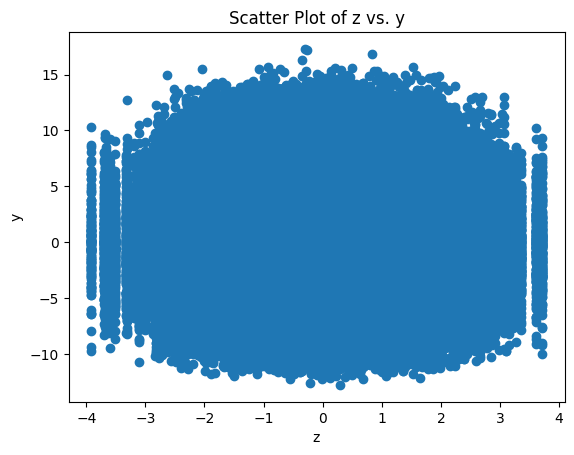

In [98]:
#distribution of z to get y
data_array = np.array(z_and_y)

# Extract z and y
z_values = data_array[:, 0]
y_values = data_array[:, 1]

# Visualize the relationship between z and y
plt.scatter(z_values, y_values)
plt.xlabel('z')
plt.ylabel('y')
plt.title('Scatter Plot of z vs. y')
plt.show()

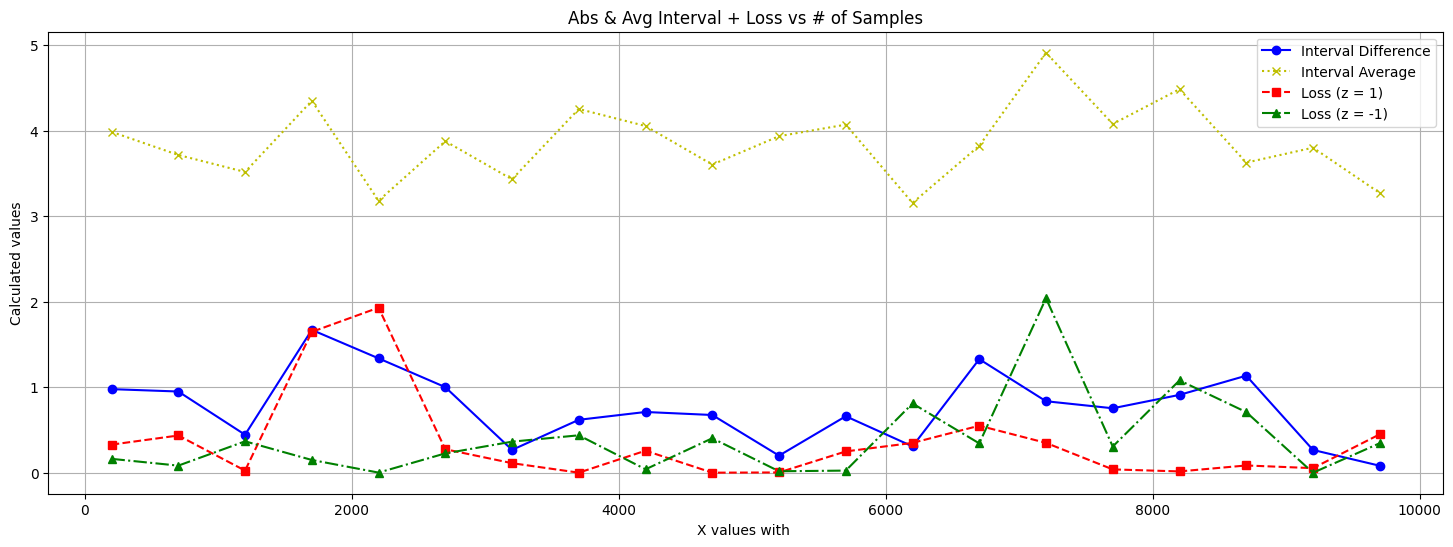

In [24]:
#constant x_test with z interval + loss func
X_test = get_data(1000)[['x1', 'x2','z','y']]
index = random.randint(0,999)
x1 = X_test.iloc[index].values[0]
x2 = X_test.iloc[index].values[1]
y = X_test.iloc[index].values[3]
target = np.array([y], dtype=np.float32)
target_tensor = torch.tensor(target, dtype=torch.float32).unsqueeze(0)

intervals = []
avg_intervals = []
losses_z1 = []
losses_z_minus1 = []
loss_fn = nn.MSELoss()

for model in models:
    predictions = []
    for z in [1, -1]:
        input_data = np.array([x1, x2, z], dtype=np.float32)
        input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():  
            preds = model(input_tensor)
        predictions.append(preds.numpy())
        
    # Use 'y' as the target for the loss calculation
    loss_z1 = loss_fn(torch.tensor(predictions[0], dtype=torch.float32), target_tensor)
    loss_z_minus1 = loss_fn(torch.tensor(predictions[1], dtype=torch.float32), target_tensor)
    
    losses_z1.append(loss_z1.item())
    losses_z_minus1.append(loss_z_minus1.item())

    #abs diff with interval 
    interval = np.abs(predictions[0] - predictions[1])
    intervals.append(interval)
    
    #avg interval
    avg = (predictions[0]+predictions[1])/2
    avg_intervals.append(avg)
    
    
intervals = np.array([interval[0][0] for interval in intervals])
avg_intervals = np.array([interval[0][0] for interval in avg_intervals])
losses_z1 = np.array(losses_z1)
losses_z_minus1 = np.array(losses_z_minus1)

#interval length of increasing x trained model with constant of 1000 x
x_values = list(np.arange(200, 10000, 500))

# Plotting
plt.figure(figsize=(18, 6))

plt.plot(x_values, intervals, marker='o', linestyle='-', color='b', label='Interval Difference')
plt.plot(x_values, avg_intervals, marker='x', linestyle=':', color='y', label='Interval Average')
plt.plot(x_values, losses_z1, marker='s', linestyle='--', color='r', label='Loss (z = 1)')
plt.plot(x_values, losses_z_minus1, marker='^', linestyle='-.', color='g', label='Loss (z = -1)')

plt.xlabel('X values with ')
plt.ylabel('Calculated values')
plt.title('Abs & Avg Interval + Loss vs # of Samples')
plt.grid(True)
plt.legend()
plt.show()

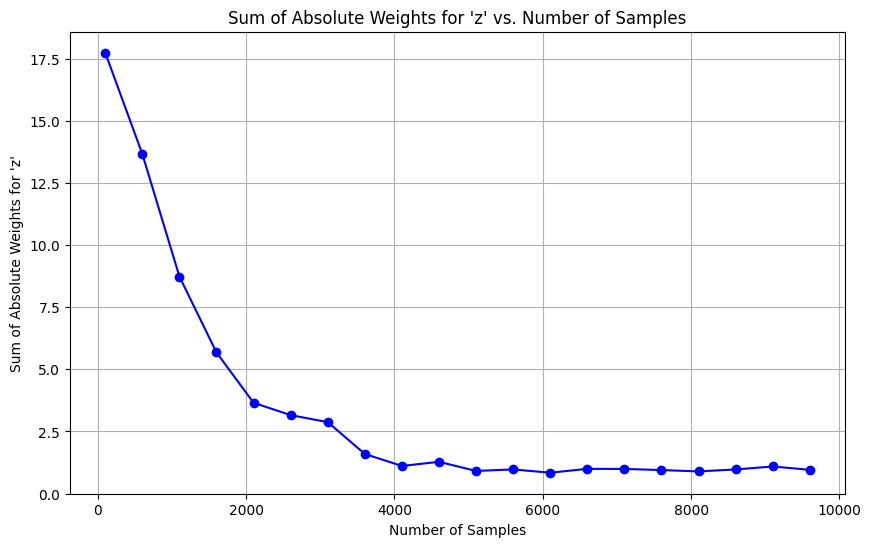

In [89]:
#as seen from the output, the weight of z has been decreasing hence it gets less irrelevant when the dataset increases
def get_z_weight(model):
    weights = model.fc1.weight.detach().numpy()
    z_weight = weights[:, 2]  
    return np.abs(z_weight).sum()

z_weights = [get_z_weight(model) for model in models]

sample_sizes = list(np.arange(100,10000,500))
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, z_weights, marker='o', linestyle='-', color='b')
plt.title("Sum of Absolute Weights for 'z' vs. Number of Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Sum of Absolute Weights for 'z'")
plt.grid(True)
plt.show()